# **Exploring Hurricane Tracks**

In this notebook, we reproduce some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

This notebook (a Python-based JupyterNotebook) provides a set of starter codes for [LEAP CPC Spring 2025](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges) [**Project 1**](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges#project-cycle-1-individual-notebook-for-exploratory-data-analysis) on

+ how to work with x-array data (given the hurricane tracks data),
+ how to visualize tracks and their moments,
+ how to carry out basic analysis on the hurricane data,
+ how to do k-means with the moments based on the paper's original idea.

All the codes in this notebook can be modified to implement research ideas.  



- Github sharing is recommended.
    - See our Github [tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md).
    - If you need help, please reach out to TA Xinyi Ke xk2161@columbia.edu.




# Step 0: Setup workspace

In [1]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



# Step 1: Install packages, import packages and download data


## 1.1 Packages

Download the required packges.

In [2]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [2]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from collections import Counter # set operations
warnings.filterwarnings('ignore')

## 1.2 Load Hurricane Data

Useful links to read more about data:

* [Official website for IBTrACS](https://www.ncdc.noaa.gov/ibtracs/). (where the data comes from)

* [Tracks in other basins for IBTrACs (other than NA)](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/) (The data downloaded below covers the tracks in the basin 'NA' (North America). So, if you want to study tracks or hurricanes from other basins, this link might be helpful.)

* Another source of data: [HURDAT2](https://oasishub.co/dataset/hurdat-2-atlantic-hurricane-database/resource/2c865c53-3fc3-4e16-9ef5-0d76a47cfcf3) (not used in this notebook, but might be useful)



*   General documentation of the data: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
*   Detailed documentation on each variable(this is particularly helpful if you want to dig more into the dataset and find what problems you are interested in solving regarding the track data): https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf


In [3]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [4]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Now, check the /data directory (left panell( to see if the data `NA_data.nc` has been saved there.

# Step 2: Visualization of hurricane tracks






### 2.2.1 Explore the dataset of hurricanes and related systems

Run the code below to see an example of information that can be obtained from the original data.\
Read the output of the following code chunks to see some examples of operations we can carry out on the dataset.

In [5]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

All the **coordinates** and **data variables** must align along the dimensions. **Attributes**, however, doesn't have to have shapes that aligned with at least one of the axes. It serves as a more auxiliary role in the dataset and provide other information that might be helpful.\
To obtain any variable from the dataset, for example 'xxx', use ***tks.xxx***.

There are 3 storms.



<GeoAxes: >

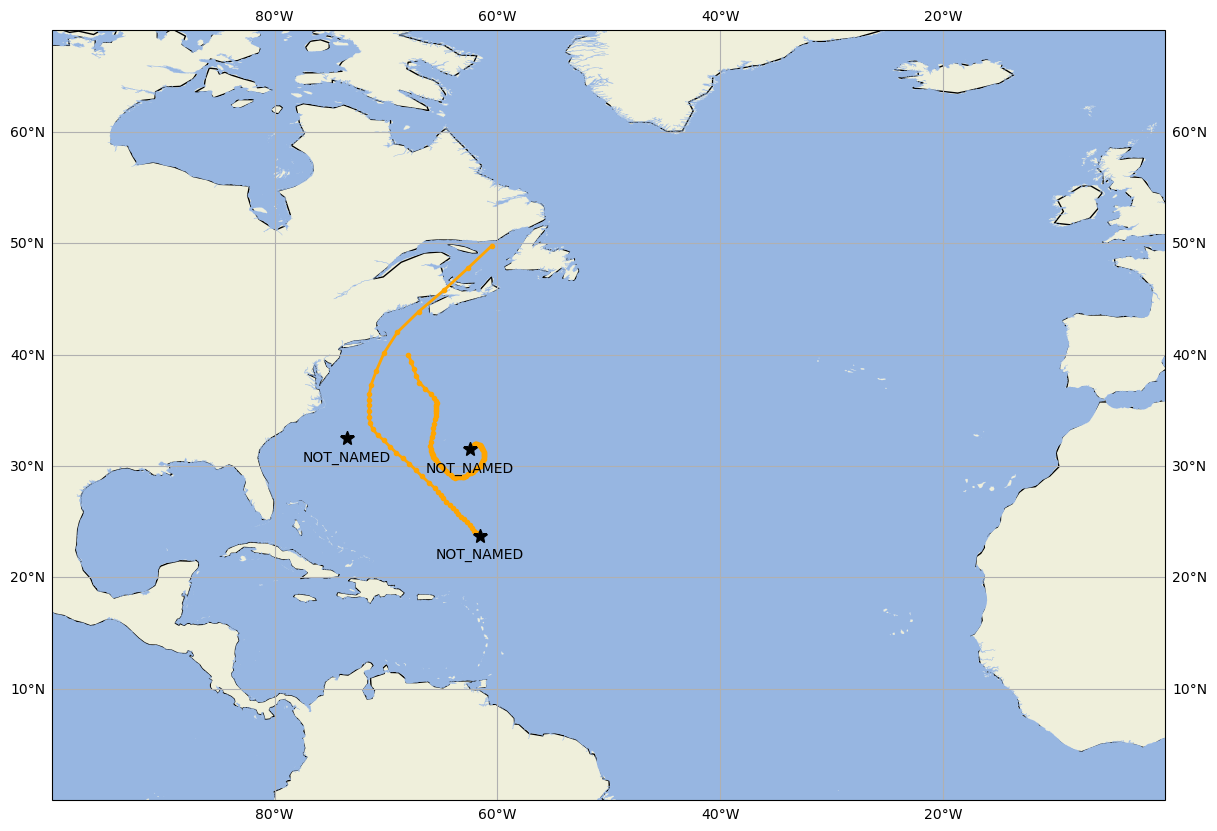

In [6]:
from func_tools.helper_functions import filter_storms
from func_tools.plotting_functions import plot_tracks

storm = filter_storms(storms=tks, storm_ids=[tks.sid.values[10:13]])
plot_tracks(storms=storm)

\\

---

\\

# Step 3: Analyze Tracks

Here we use moment as a numerical characteristic of a track. [Ophelia (2005)](https://en.wikipedia.org/wiki/Hurricane_Ophelia_(2005)) is given as an example track.



## 3.1 Define the moments of a track

Below codes plot ONE track and its moments based on the paper's idea.

So, what we want to do here is to find a summary statistics for the track. Here the method below calculates the weighted first and second moments of a track, which would ouput a 5-entry vector which can be used in clustering and analysis purpose.

M1 here stands for the first moment. When the weights $w$ are set to 1, it simply calculating the means of the longitude and latitude vectors. Changing the weights to other variables, such as wind speed, storm speed, temperatures, etc. should result in different clustering. In the paper, setting all the weights to 1 is used.

M2 stands for the second moment. When the weights are 1, it is calculating the variances and covariance of longitude and latitude vectors of a given track.

$r$ is a two-dimensional vector that corresponds to $(x,y)$, i.e., longitude and latitude.

See [Nakamura et al (2009)](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) for more details on the notation.

$$
\begin{aligned}
\mathbf{M 1}&=\frac{1}{A} \int w(\mathbf{r}) \mathbf{r} d x d y=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right) \mathbf{r}_{i} \\
\mathbf{M 2} &=\frac{1}{A} \int w(\mathbf{r})(\mathbf{r}-\mathbf{M 1})^{2} d x d y
=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right)\left(\mathbf{r}_{i}-\mathbf{M 1}_{i}\right)^{2}
\end{aligned}
$$


## 3.1.2 Calculate moments and visualize for one system

In [7]:
from func_tools.helper_functions import get_storms_with_moments
from func_tools.plotting_functions import plot_track_moments

# calculate moments (It takes a moment to calculate the moments)
storms = get_storms_with_moments(storms=tks)


There are 1 storms.

There are 1 storms.

There are 1 storms.



<GeoAxes: >

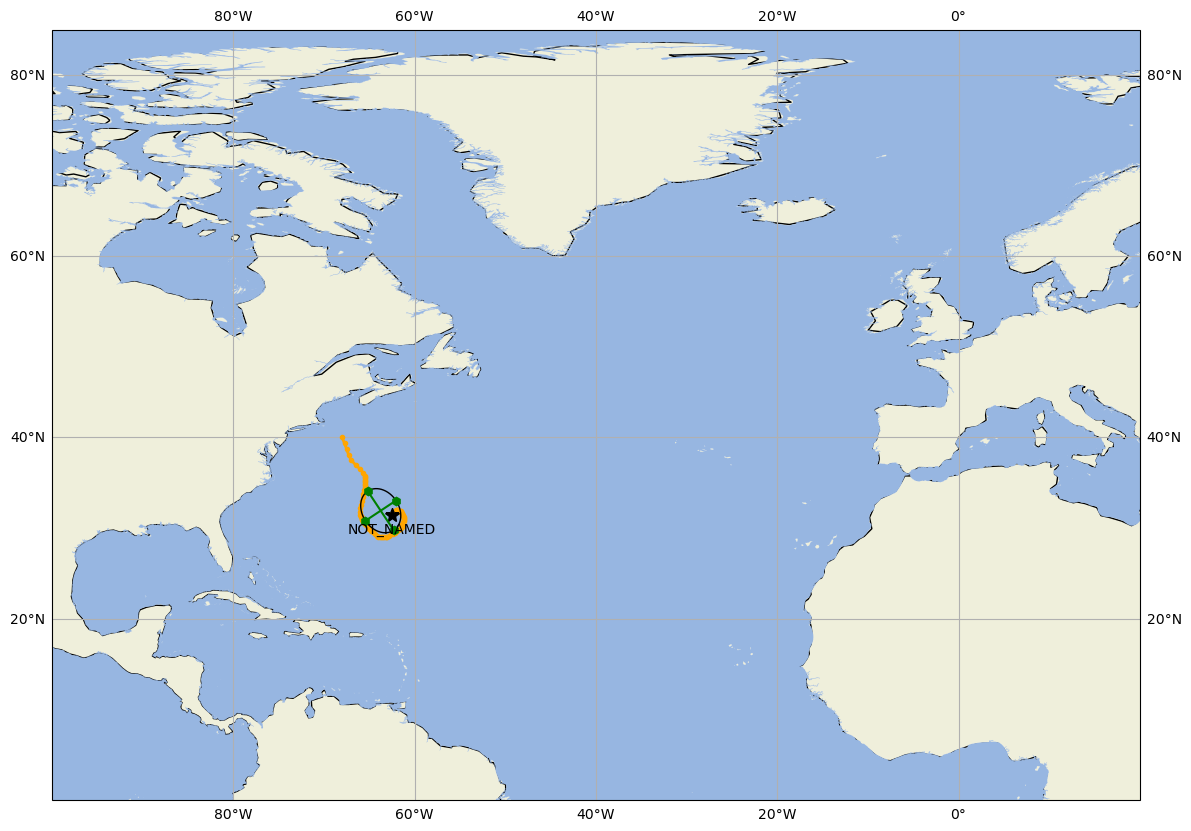

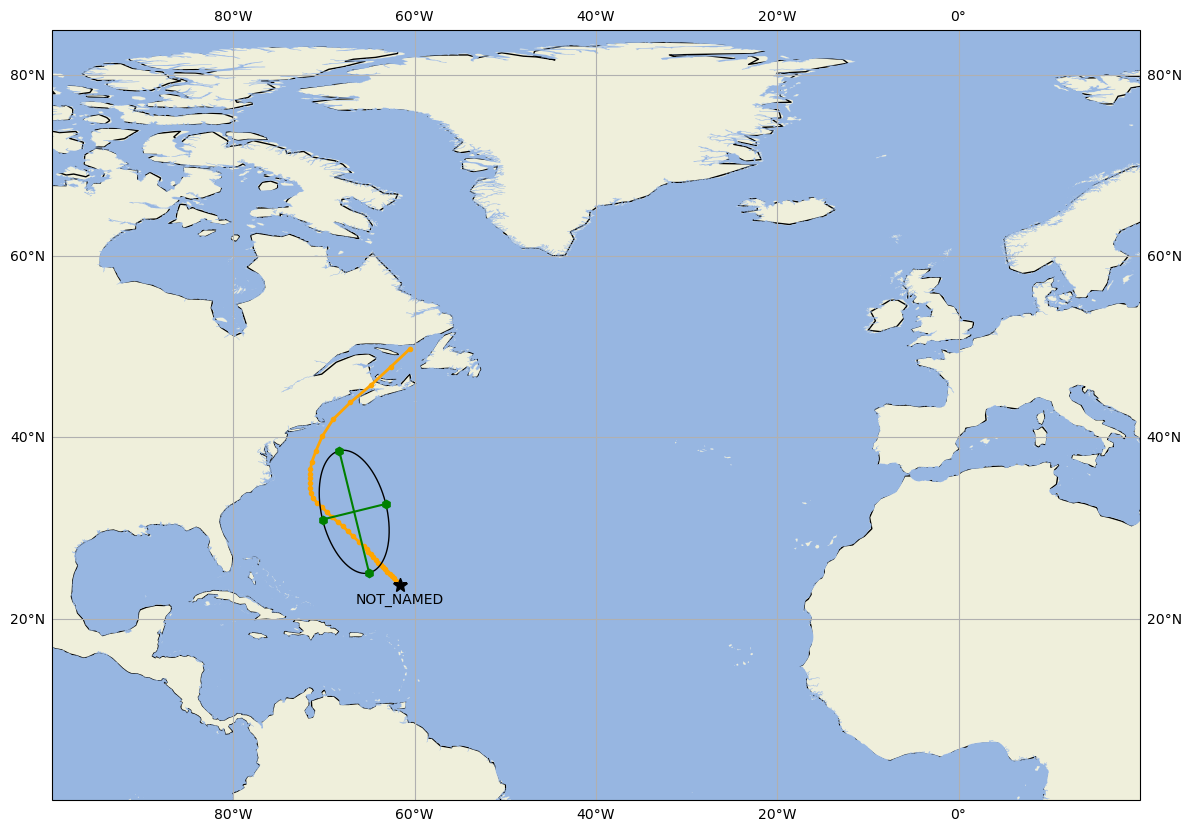

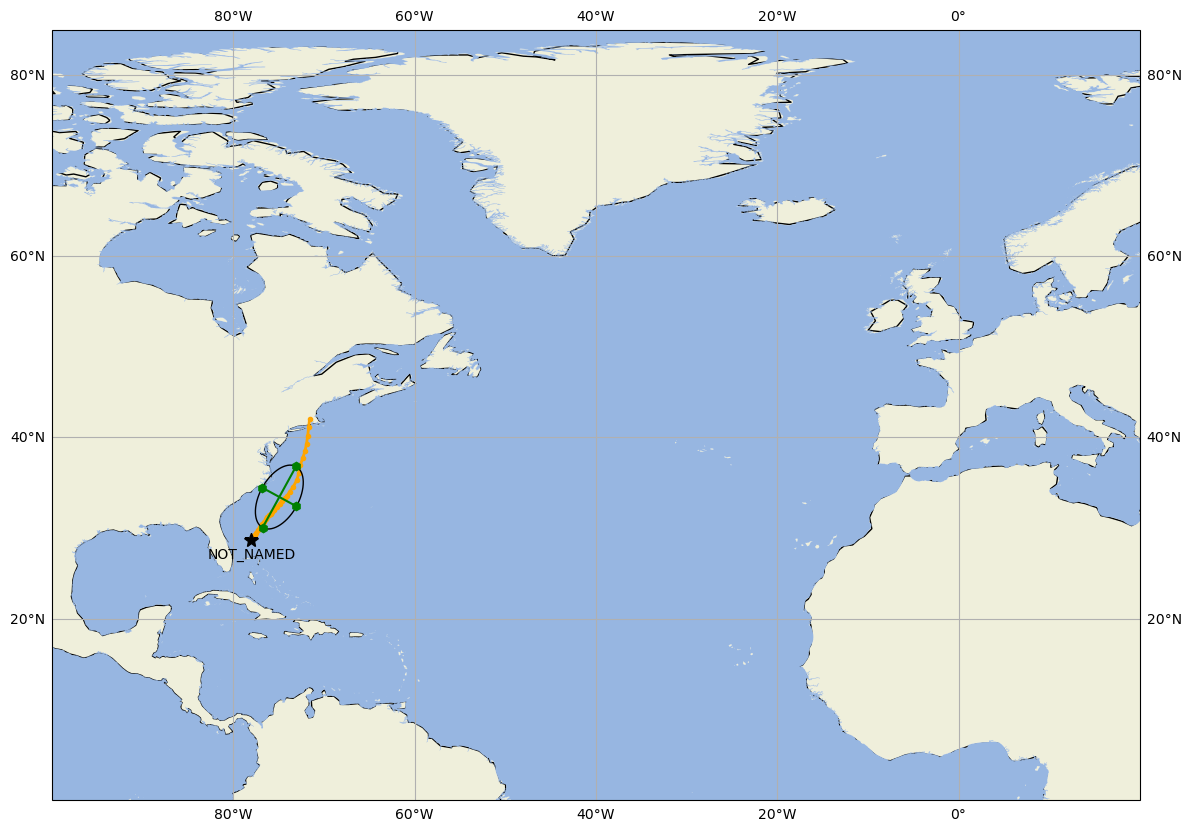

In [8]:
storm = filter_storms(storms=storms, storm_ids=[tks.sid.values[11:14]])
plot_track_moments(storms=storm, extent=[-100, 20, 0, 80], label=True)

## 3.2 K-means clustering using moments for all systems

In this section, K-means clustering is carried out on the historical tracks with the idea adopted from the paper. As the data are different, nuances with the clustering results are expected.

In [9]:
from func_tools.helper_functions import storms_kmeans, not_nan_mask

def get_values(storms) -> list:
    mask = not_nan_mask(storms=storms)
    return np.array([storms.lon_mean.values[mask],
                        storms.lat_mean.values[mask],
                        storms.lon_std.values[mask],
                        storms.lat_std.values[mask],
                        storms.lon_lat_cov.values[mask]]).T

__CLUSTERS__ = 6
storms = storms_kmeans(storms=storms, k_clusters=__CLUSTERS__, get_variables=get_values)

### 3.2.1 Find inertia values to determine the right number of clusters

Run the clustering for a range of cluster numbers and extract the interia value

Inertia values from sklearn are evaluated with the "elbow method" to determine the optimal value of the clusters.\
Inertia, or cost, is calculated as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. See the documentation for [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for more details.

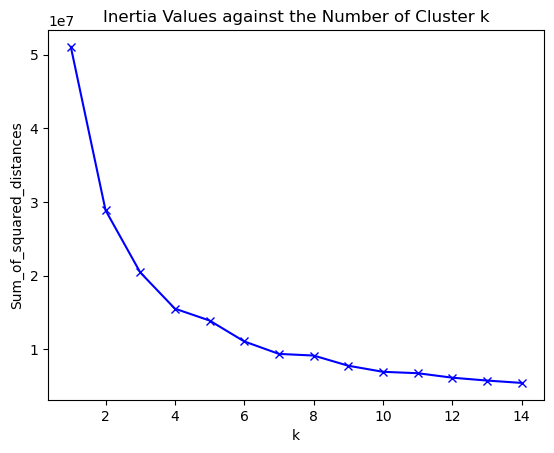

In [10]:
from func_tools.helper_functions import kmeans_inertia, get_storms_moments

kmeans_inertia(storms=storms, get_variables=get_storms_moments, max_clusters=15)

From the plot above, 6 is probably a good choice for the number of clusters.\
Below codes plot the K-means results. The locations on the map are the weighted first moment of the hurricane tracks. In the example code, the weights were set to be 1 meaning that the first moment is the sample mean (see section 3.1 description).

Note that if you run the code again the ordering of the clusters changes

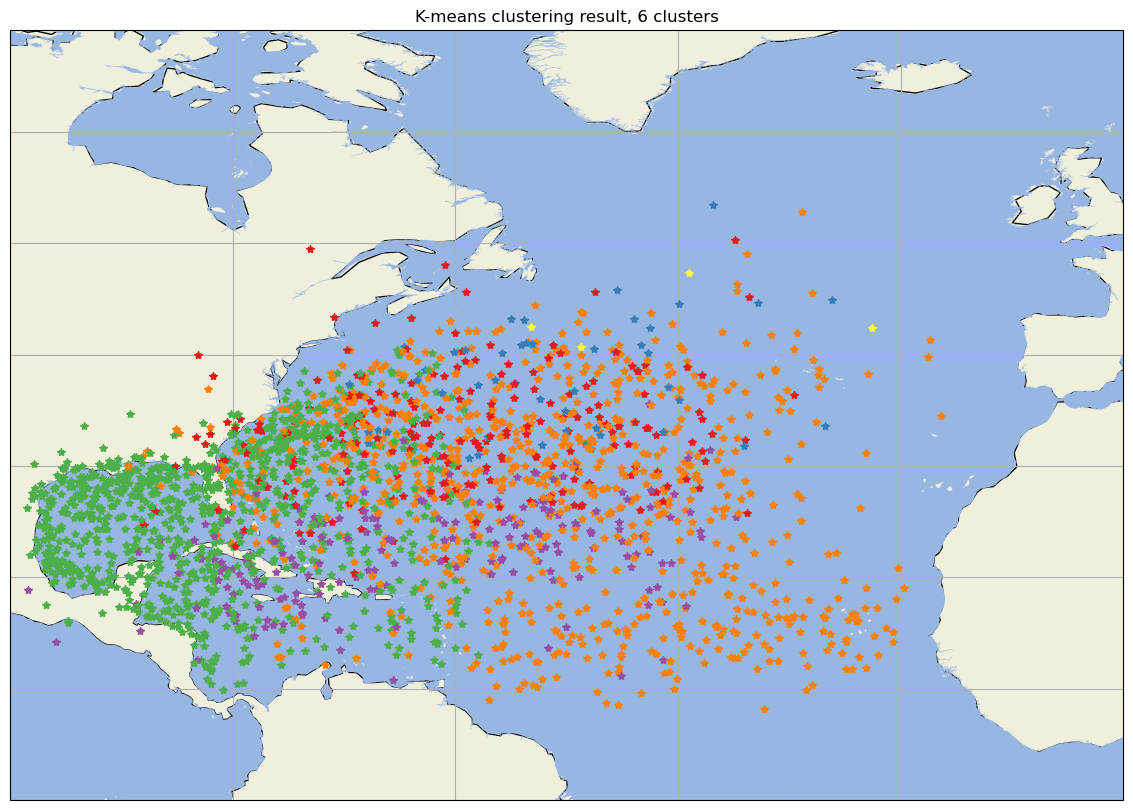

In [11]:
from func_tools.plotting_functions import plot_centroids
plot_centroids(storms=storms, title_name=f'K-means clustering result, {__CLUSTERS__} clusters', cmap_name='Set1')

## PDI

In [ ]:
velocity = tks.wmo_wind * 0.51444
velocity

In [ ]:
# Convert time values to datetime64 format
new_time = pd.to_datetime(tks['time'].values.flatten(), unit='D', origin=pd.Timestamp('1858-11-17'))

# Convert to numpy array and reshape the new time coordinate to match the original dimensions (storm, date_time)
new_time = new_time.to_numpy().reshape((tks.dims['storm'], tks.dims['date_time']))

# Create a new dataset with the converted time values
new_tks = tks.copy()
new_tks['time'] = (('storm', 'date_time'), new_time)

## Standardization of Variables

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

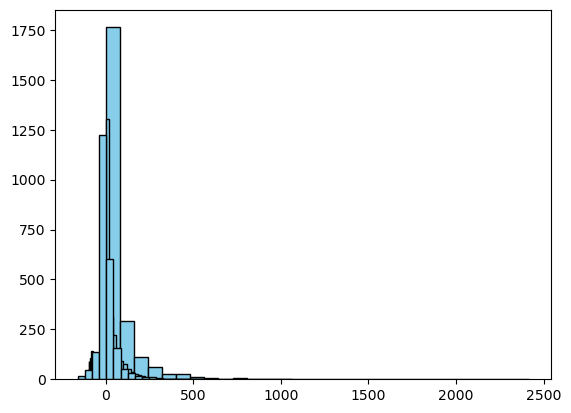

In [25]:
# Histogram of each variable
number_of_variables = len(moment_lst[0])
for j in range(number_of_variables):
    plt.hist([moment_lst[i][j] for i in range(len(moment_lst))], bins=30, color='skyblue', edgecolor='black') 

In [21]:
def normalize(variables: np.array):
    mx = np.max(variables, axis=0)
    mn = np.min(variables, axis=0)
    return (variables - mn) / (mx - mn)
moment_lst_sdz = normalize(np.array(moment_lst))

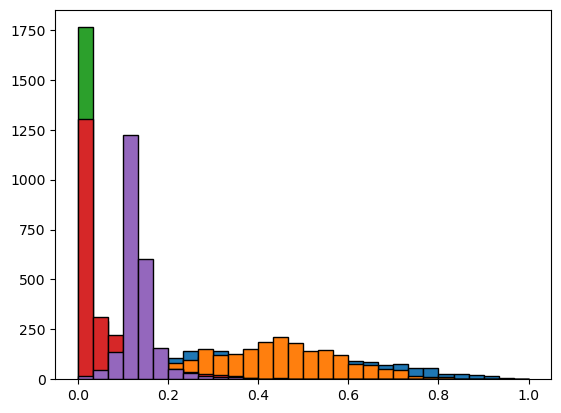

In [22]:
# Histogram of each variable
number_of_variables = len(moment_lst_sdz[0])
for j in range(number_of_variables):
    plt.hist([moment_lst_sdz[i][j] for i in range(len(moment_lst_sdz))], bins=30, edgecolor='black')

## DBSCAN Clustering

In [25]:
db = DBSCAN(eps=0.03, min_samples=20).fit(moment_lst_sdz)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

5

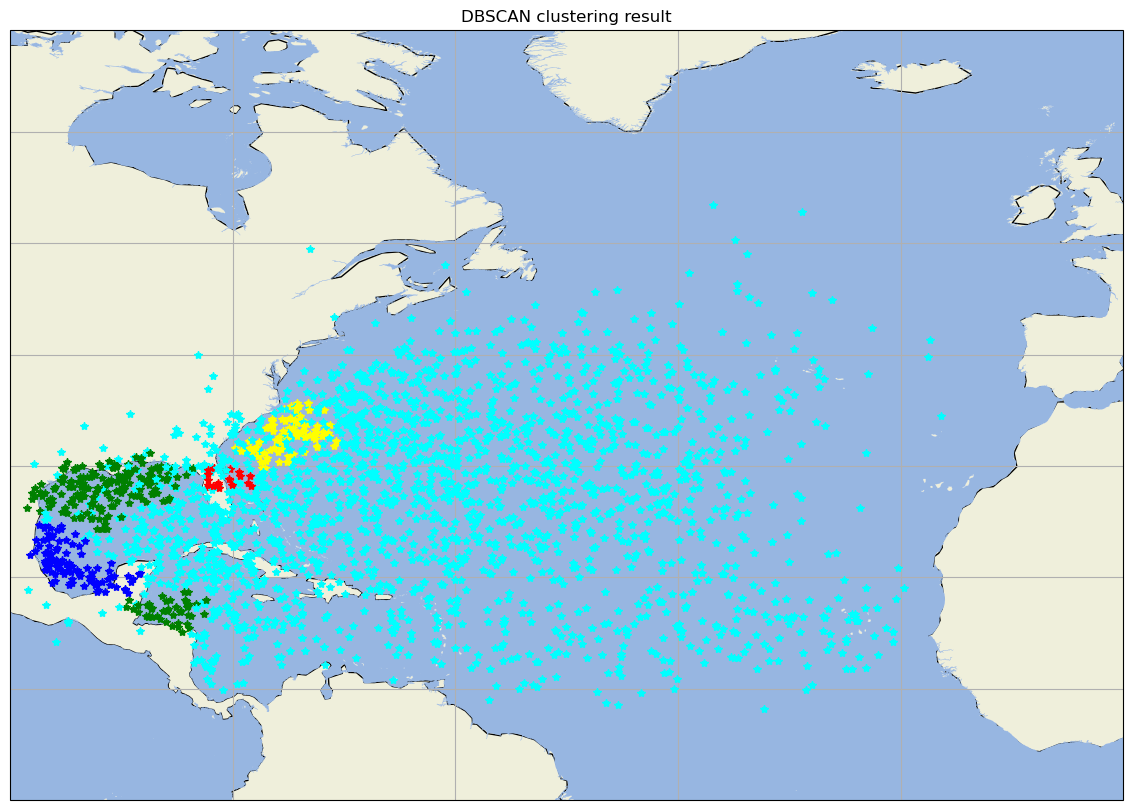

In [29]:
from func_tools.plotting_functions import plot_centroids

plot_centroids(moment_list=moment_lst, labels=labels, title_name='DBSCAN clustering result')


Text(0.5, 1.0, 'K-means clustering result')

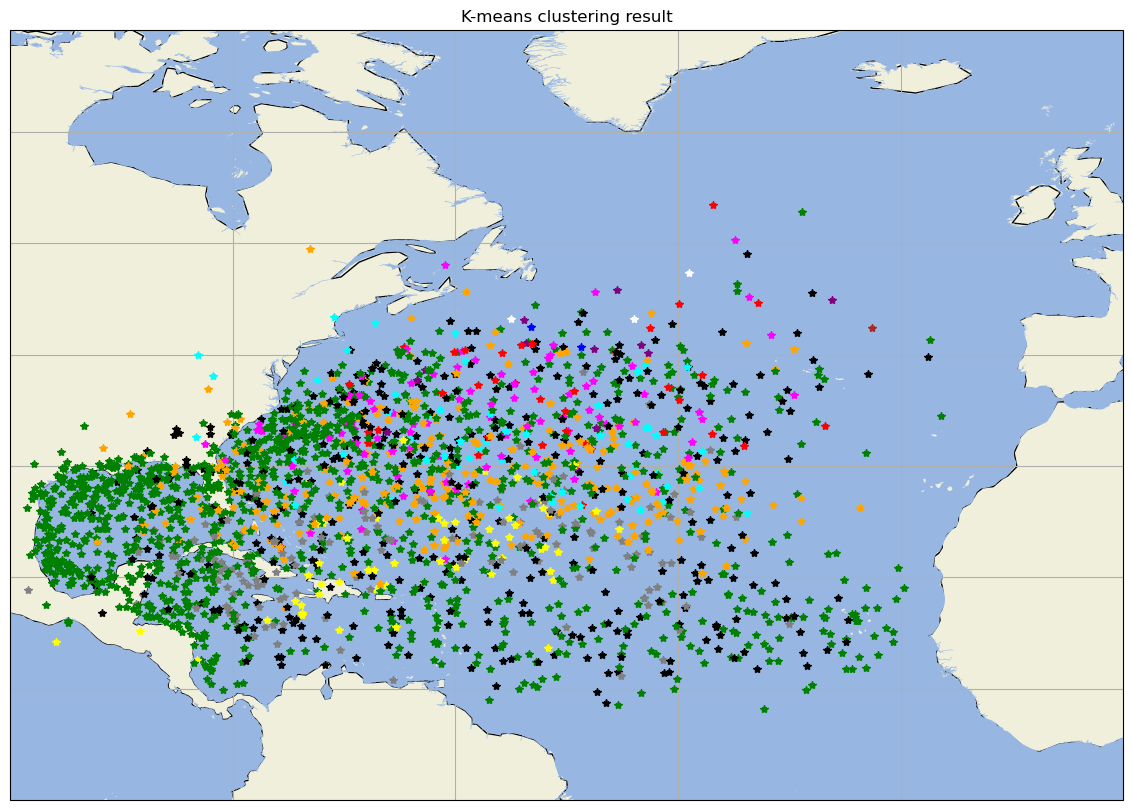

In [18]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result')

## 3.5 Other Summary Statistics and example comparisons

### 3.5.1 Distance traveled

Compare the $\Delta$ lon and $\Delta$ lat between these two interval of years (2000\~2010 against 1990\~1999).\
$\Delta$ lon is the maximum value of distance of travel of a hurricane from its start to its end location in its longitude (same as the what [np.ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html) does).

194 storms between year 2000 and 2010,         133 storms between year 1990 and 1999.



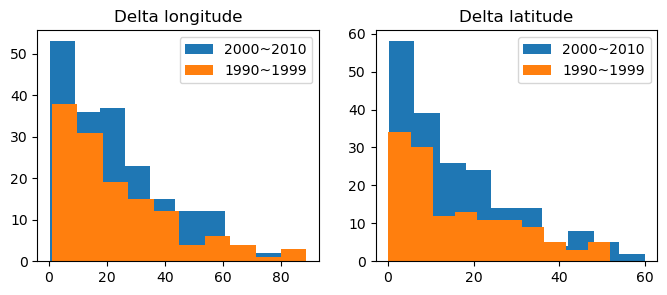

In [19]:
def delta_lon_lat(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  return [np.ptp(lon_lst), np.ptp(lat_lst)]

storms_1 = tks.where((tks.season >= 2000) & (tks.season <= 2010), drop=True)
storms_2 = tks.where((tks.season >= 1990) & (tks.season <= 1999), drop=True)
N1, N2 = storms_1.dims['storm'], storms_2.dims['storm']
print(f"{storms_1.dims['storm']} storms between year 2000 and 2010, \
        {storms_2.dims['storm']} storms between year 1990 and 1999.\n")

d_lst_1 = [delta_lon_lat(storms_1.sel(storm=i)) for i in range(N1)]
d_lst_1 = np.transpose(d_lst_1)

d_lst_2 = [delta_lon_lat(storms_2.sel(storm=i)) for i in range(N2)]
d_lst_2 = np.transpose(d_lst_2)


fig, axs = plt.subplots(1,2,figsize=(8,3)) # gridspec_kw={'height_ratios': [1, 2]}

for j in range(2):
  axs[j].hist(d_lst_1[j], label='2000~2010')
  axs[j].hist(d_lst_2[j], label='1990~1999')
  axs[j].legend()
axs[0].title.set_text('Delta longitude')
axs[1].title.set_text('Delta latitude')



It can be seen from the above graphs that hurricanes traveled greater distance in 2000\~2010 compared to 1990~1999.

### 3.5.2 Naming hurricanes

Many hurricane in the data set have a name. We use the codes below to visualize the predominant gender of the names used.

Here is some [history of the hurricane naming system](https://www.nhc.noaa.gov/aboutnames_history.shtml):

+ 1953 - 1977: The United States only used female names for hurricanes.
+ 1978 - present: Both female and male names are used.

We use the [gender.Detector](https://pypi.org/project/gender-guesser/) to automatically infer the predominant gender of each name found in the data set.

Note that in the output below, a very few percentage of names are marked 'Andy' which means it's a gender-neutral or an unisex name (are you woke enough?).

Ophelia is deemed a female name.

In total there are 226 named hurricanes during 1953-1979.

In total there are 589 named hurricanes after 1979.



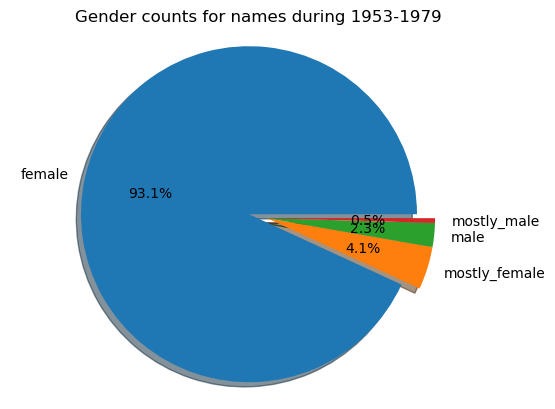

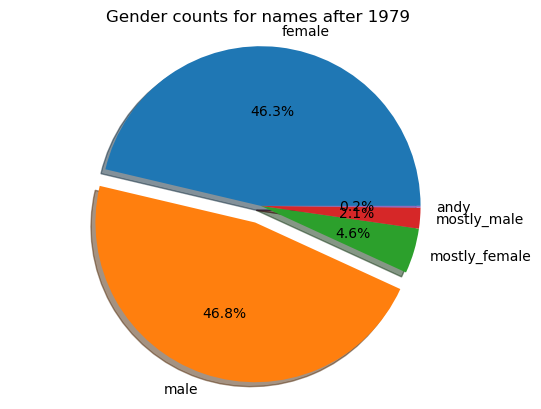

In [20]:
def plot_pie_chart(storms, period):
  # a function to plot pie chart the genders of names given a bunch of storms

  all_names = [str(name)[2:-1] for name in storms.name.values]
  all_names = [x for x in all_names if x!='NOT_NAMED'] # clean the unnamed cases
  print(f"In total there are {len(all_names)} named hurricanes {period}.\n")

  gender_lst = [d.get_gender(name) for name in all_names]
  gender_lst = [x for x in gender_lst if x!='unknown'] # clean the unknown names

  # Data (counts)
  genders_category = Counter(gender_lst).keys()  # equals to list(set(list))
  genders_count = Counter(gender_lst).values() # counts the elements' frequency
  explode = [0.11 if x==max(genders_count) else 0 for x in genders_count]

  # plot
  fig1, ax1 = plt.subplots()
  ax1.pie(genders_count, explode=explode, labels=genders_category, autopct='%1.1f%%',
          shadow=True, startangle=0)
  ax1.axis('equal')
  ax1.title.set_text(f'Gender counts for names {period}')



d = gender.Detector(case_sensitive=False)
gen = d.get_gender("Ophelia")
print(f"Ophelia is deemed a {gen} name.\n")
storms = tks.where((tks.season >=1953)&(tks.season <=1979), drop=True)
storms_1 = tks.where((tks.season >=1979), drop=True)

plot_pie_chart(storms, period='during 1953-1979')
plot_pie_chart(storms_1, period='after 1979')


### 3.5.3 Not all systems are hurricanes. Classification of systems - hurricane? tropical storm? tropical depression? 

Below codes summarize the types of all the classified hurricanes in the record (in the NA basin).

Storm classification by usa_status (according the documentation this is not the unique way of classifying the tracks)

Status of system. Options:
* DB - disturbance,
* TD - tropical depression,
* TS - tropical storm,
* TY - typhoon,
* ST - super typhoon,
* TC - tropical cyclone,
* HU,HR - hurricane,
* SD - subtropical depression,
* SS - subtropical storm,
* EX - extratropical systems,
* PT - post tropical,
* IN - inland,
* DS - dissipating,
* LO - low,
* WV - tropical wave,
* ET - extrapolated,
* MD - monsoon depression,
* XX - unknown.
 
documentation at https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf

In [21]:
all_types = tks.usa_status.values
print(np.shape(all_types))

(2344, 360)


Notice the shape is (2344, 360), indicating that the classification of each system evolves along the 'date_time' axis. \
To identify a class for system across its whole track, we can define it as the one class that has the highest frequency throughout its lifetime.


There are 2002 systems in the North Atlantic that were classified at least once during its lifetime.



Text(0.5, 1.0, 'Counts of the classification of all the tracks')

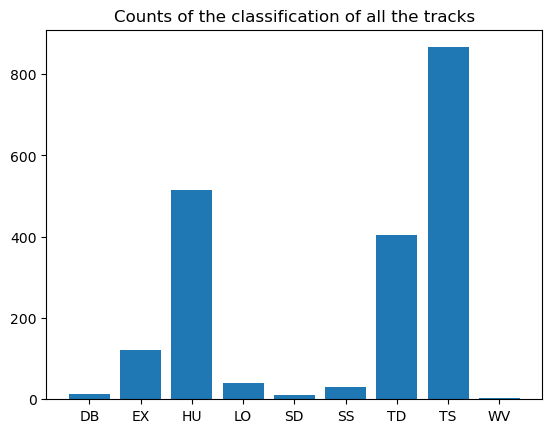

In [22]:
class_lst = []

for i in range(tks.dims['storm']):
  types = [str(x)[2:-1] for x in all_types[i]]
  types = [x for x in types if x!='']
  # many of the recorded tracks are never given a class
  if len(types)==0: continue
  class_category = Counter(types).most_common(1)[0][0] # Select the most frequent class
  class_lst.append(class_category)

print(f'There are {len(class_lst)} systems in the North Atlantic that were classified at \
least once during its lifetime.\n')

# This helps center the labels.
labels, counts = np.unique(class_lst, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Counts of the classification of all the tracks')

# References

+ Nakamura, Jennifer, et al. "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml).

+ Nakamura, Jennifer, et al. "Western North Pacific tropical cyclone model tracks in present and future climates." Journal of Geophysical Research: Atmospheres 122.18 (2017): [9721-9744](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027007).